In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import cv2
import torch
import os
import glob
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

2024-06-23 08:48:21.456730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 08:48:21.456832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 08:48:21.587801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
! wget http://images.cocodataset.org/zips/test2014.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-06-23 08:48:32--  http://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.159.9, 3.5.3.159, 3.5.29.233, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.159.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6660437059 (6.2G) [application/zip]
Saving to: 'test2014.zip'

test2014.zip        100%[===================>]   6.20G  45.6MB/s    in 2m 19s  

2024-06-23 08:50:51 (45.7 MB/s) - 'test2014.zip' saved [6660437059/6660437059]



In [ ]:
!unzip test2014.zip

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
def add_salt_and_pepper_noise(image, salt_prob=0.002, pepper_prob=0.002):
     noisy_image = np.copy(image)
     total_pixels = image.shape[0] * image.shape[1]
    
     num_salt = np.ceil(salt_prob * total_pixels)
     coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
     noisy_image[coords[0], coords[1], :] = 1

     num_pepper = np.ceil(pepper_prob * total_pixels)
     coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]
     noisy_image[coords[0], coords[1], :] = 0

     return noisy_image

def add_poisson_noise(image):
    vals = len(np.unique(image))
    vals = 3 ** np.ceil(np.log2(vals))
    noisy_image = np.random.poisson(image * vals) / float(vals)
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image*0.5

def add_gaussian_noise(image, mean=0, std=0.07):
    image = image.astype(np.float32)
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)
    
    return noisy_image

In [26]:
class NoiseImageDataset(Dataset):
    
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target_size = (100,100)
        image = cv2.resize(image,target_size,interpolation=cv2.INTER_LINEAR)
        
        image = image.astype(np.float32) / 255.0
        
        noise_image = add_salt_and_pepper_noise(image)
        noise_image = add_poisson_noise(noise_image)
        noise_image = add_gaussian_noise(noise_image)
        
        image = torch.tensor(image).permute(2, 0, 1)
        noise_image = torch.tensor(noise_image).permute(2, 0, 1)
        
        return  noise_image.to(device) ,image.to(device)

In [27]:
image_directory = '/kaggle/working/test2014'
image_paths = glob.glob(os.path.join(image_directory, '*.jpg'))
dataset = NoiseImageDataset(image_paths)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

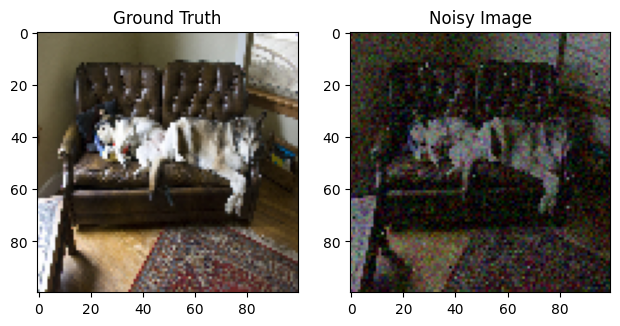

In [28]:
#Visualizing first image of first batch in dataloader for reference :
for index ,(noise,image) in enumerate(dataloader):
    if index == 0:
        noise = noise[0].squeeze().permute(1, 2, 0).cpu().numpy()
        image = image[0].squeeze().permute(1, 2, 0).cpu().numpy()

        noise = (noise * 255).astype(int)
        image = (image * 255).astype(int)
        
        plt.figure(figsize=(80, 20))
        
        plt.subplot(1,20,2)
        plt.title('Noisy Image')
        plt.imshow(noise, cmap='gray')
        
        plt.subplot(1,20,1)
        plt.title('Ground Truth')
        plt.imshow(image, cmap='gray')

        plt.show()
        
    if index == 1:
        break;

In [29]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(256, 128)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(128, 64)
        
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))

        dec3 = self.upconv3(enc3)
        dec3 = self.decoder3(torch.cat([dec3, enc2], dim=1))  # skip connection

        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat([dec2, enc1], dim=1))  # skip connection

        dec1 = self.upconv1(dec2)
        dec1 = self.conv(dec1)
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))  # skip connection

        output = self.final_conv(dec1)
        return output


In [30]:
class PerceptualLoss(nn.Module):
    def __init__(self, layer_ids):
        super(PerceptualLoss, self).__init__()
        vgg16 = models.vgg16(pretrained=True).features.eval()  
        self.layer_ids = layer_ids
        self.vgg16 = vgg16
        for param in self.vgg16.parameters():
            param.requires_grad = False 
        self.criterion = nn.MSELoss()

    def forward(self, output, target):
        output_fea = self.get_features(output.float())
        target_fea = self.get_features(target.float())
        
        loss = 0
        for o_f, t_f in zip(output_fea, target_fea):
            loss += self.criterion(o_f, t_f)
        return loss
    
    def get_features(self, x):
        features = []
        for i, layer in enumerate(self.vgg16):
            x = layer(x)
            if i in self.layer_ids:
                features.append(x)
        return features

In [31]:
layer_ids = [8, 15, 22, 29]
percep_loss = PerceptualLoss(layer_ids).to(device)
net = UNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=(1e-3))
num_epochs = 20

In [32]:
epoch_loss_n = []
epoch_n = []
psnr_e = []
scaler = GradScaler()

In [33]:
def psnr(gt_image, pred_images, max_val=1.0):
    mse = torch.mean((gt_image - pred_images) ** 2)
    psnr_val = 10 * torch.log10((max_val ** 2) / mse)
    return psnr_val

In [34]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

In [ ]:
for epoch in range(num_epochs):
    net.train()
    
    epoch_loss = 0.0
    psnr_sum = 0.0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for image,noise in progress_bar:
        
        image = image.to(device)
        noise = noise.to(device)
        
        optimizer.zero_grad()

        with autocast():
            output = net(noise)
            pixel_loss = nn.MSELoss()(output, image)
            p_loss = percep_loss(output, image)
            loss = pixel_loss + 0.01 * p_loss
                
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
        
        psnr_batch = psnr(image, output)
        psnr_sum += psnr_batch
        
        del image, noise, output, pixel_loss, loss,p_loss
        torch.cuda.empty_cache()

    avg_epoch_loss = epoch_loss/len(dataloader)
    avg_psnr = psnr_sum / len(dataloader)
    
    epoch_loss_n.append(avg_epoch_loss)
    epoch_n.append(epoch + 1)
    psnr_e.append(avg_psnr)

    if epoch+1 == 15:
        torch.save(net.state_dict(),f"/kaggle/working/15_unet_ploss_vgg19.pth")
    

    print(f"Epoch : {epoch+1} , Loss : {avg_epoch_loss} , PSNR : {avg_psnr}")

torch.save(net.state_dict() , "/kaggle/working/20_unet_ploss_vgg19.pth")


Epoch 1/20:   7%|▋         | 185/2549 [00:53<11:19,  3.48it/s]